<a href="https://colab.research.google.com/github/p-kris10/Neural-Style-Transfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Style Transfer Using Optimization Method

In [ ]:
import torch
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
from collections import namedtuple
import cv2 as cv
import os
import matplotlib.pyplot as plt

#Get pretrained VGG model

In [ ]:
model = models.vgg16(pretrained=True).features

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
indexes = []
for i in enumerate(model):
  if("Max" in str(i[1])):
    indexes.append(i[0])

In [ ]:
indexes

[4, 9, 16, 23, 30]

In [ ]:
layer_names = ['relu_1', 'relu_8', 'relu_15', 'relu_22'] # Layers we will be exposing for getting feature maps

In [ ]:
#model with exposed vectors

class VGG(nn.Module):
  def __init__(self,requires_grad=False, show_progress=False):
    super().__init__()
    pretrained_features = models.vgg16(pretrained=True, progress=show_progress).features
    self.layer_names = ['relu_1', 'relu_8', 'rlu_15e', 'relu_22']
    self.content_feature_maps_index = 1

    self.style_feature_maps_indices = list(range(len(self.layer_names)))

    ## each block stops before the maxpool layer in the architecture
    self.block1 = nn.Sequential()
    self.block2 = nn.Sequential()
    self.block3 = nn.Sequential()
    self.block4 = nn.Sequential()

    for i in range(4):
      self.block1.add_module(str(i),pretrained_features[i])
    for i in range(4,9):
      self.block2.add_module(str(i),pretrained_features[i])
    for i in range(9,16):
      self.block3.add_module(str(i),pretrained_features[i])
    for i in range(16,23):
      self.block4.add_module(str(i),pretrained_features[i])
    if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False
    

  def forward(self,x):
    x = self.block1(x)
    relu_1 = x
    x = self.block2(x)
    relu_8 = x
    x = self.block3(x)
    relu_15 = x
    x = self.block4(x)
    relu_22 = x
    vgg_outputs = namedtuple("VggOutputs", self.layer_names)
    out = vgg_outputs(relu_1, relu_8, relu_15, relu_22)
    return out


  

In [ ]:
img_size = 400
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [ ]:
IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
IMAGENET_STD_NEUTRAL = [1, 1, 1]

In [ ]:
device

device(type='cuda')

#Utils

In [ ]:
transformations = transforms.Compose(
    [
    #  transforms.Resize((img_size,img_size)),
     transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255)),
    transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ]

)

In [ ]:
def calc_shape(pth):
  img = Image.open(pth)
  w,h = img.size
  img_w = int(400 * (w/h))
  return (img_w,400)

def load_img(pth,shape):
  img = Image.open(pth)
  img = img.resize(shape)
  #apply transformations
  img = transformations(img).unsqueeze(0)
  return img.to(device)

In [ ]:
def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

In [ ]:
def get_model(device):
  model = VGG().to(device)
  content_feature_maps_index = model.content_feature_maps_index
  style_feature_maps_indices = model.style_feature_maps_indices
  layer_names = model.layer_names
  content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
  style_fms_indices_names = (style_feature_maps_indices, layer_names)
  return model.to(device).eval(), content_fms_index_name, style_fms_indices_names

In [ ]:
def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))
  
def calc_loss(neural_net, gen_img, target_representations, content_feature_maps_index, style_feature_maps_indices,alpha,beta,gamma):
  """ 
  neuralnet - > model

  gen_img -> image being optimized

  target_representations -> array of size 2 containing content representaiton of
  orignal image and style representation of style image(list of gram matrices)

  content_feature_maps_index -> tuple of index of the layer used for content represnetaion defined in the model.layer_names and corresponding name

  style_feature_maps_indices -> tuple of indices of the layer used for style representations and name of the layers

  alpha,beta,gamma -> weights for loss equation

  """
  target_content_rep = target_representations[0]
  target_style_rep = target_representations[1]

  current_gen_feat = neural_net(gen_img) 

  current_gen_rep = current_gen_feat[content_feature_maps_index].squeeze(axis=0) # current representation requiresgrad

  content_loss = nn.MSELoss(reduction='mean')(target_content_rep, current_gen_rep) #loss requires grad

  style_loss = 0.0

  current_style_rep =  [gram_matrix(x) for cnt, x in enumerate(current_gen_feat) if cnt in style_feature_maps_indices]

  #style loss is the sum of losses for each gram matrix representaion / N
  for gram_gt, gram_hat in zip(target_style_rep, current_style_rep):
      style_loss += nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
  style_loss /= len(target_style_representation)

  tv_loss = total_variation(gen_img)

  total_loss = alpha*content_loss + beta*style_loss + gamma*tv_loss 

  return total_loss, content_loss, style_loss, tv_loss



In [ ]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the height
            current_height, current_width = img.shape[:2]
            new_height = target_shape
            new_width = int(current_width * (new_height / current_height))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # this need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img


def prepare_img(img_path, target_shape, device):
    img = load_image(img_path, target_shape=target_shape)

    # normalize using ImageNet's mean
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    img = transform(img).to(device).unsqueeze(0)

    return img


In [ ]:
def define_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices,alpha,beta,gamma):
  def tuning_step(gen_img):
        total_loss, content_loss, style_loss, tv_loss = calc_loss(neural_net, gen_img, target_representations, content_feature_maps_index, style_feature_maps_indices,alpha,beta,gamma)
        # Computes gradients
        total_loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss
  return tuning_step

In [ ]:
def get_uint8_range(x):
    if isinstance(x, np.ndarray):
        x -= np.min(x)
        x /= np.max(x)
        x *= 255
        return x
    else:
        raise ValueError(f'Expected numpy array got {type(x)}')

In [ ]:
def save_img(optimizing_img, dump_path, num_of_iterations, should_display=True):

    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)  # swap channel from 1st to 3rd position: ch, _, _ -> _, _, chr

    out_img_name = str(num_of_iterations) + "_result.jpg"

    dump_img = np.copy(out_img)
    #inversing normalizated output
    dump_img += np.array(IMAGENET_MEAN_255).reshape((1, 1, 3))
    dump_img = np.clip(dump_img, 0, 255).astype('uint8')
    cv.imwrite(os.path.join(dump_path, out_img_name), dump_img[:, :, ::-1])
    plt.imshow(dump_img)

In [ ]:
shape = calc_shape("/content/figures.jpg")# add path to content image
original_img = load_img("/content/figures.jpg",shape)# add path to content image
style_img = load_img("/content/vg_starry_night.jpg",shape)# add path to style image
generated_img = Variable(original_img , requires_grad=True)# initialize image for optimization

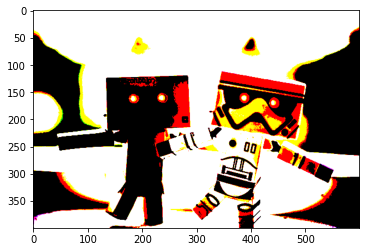

In [ ]:
plt.imshow(original_img.cpu().squeeze(0).permute(1,2,0))

In [ ]:
neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = get_model(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
save_image(generated_img,"generated.png")   

In [ ]:
#get feature maps
original_img_feature_maps = neural_net(original_img)
style_img_feature_maps = neural_net(style_img)

target_content_representation = original_img_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0) # taking one of the feature map of the content representation
target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_feature_maps) if cnt in style_feature_maps_indices_names[0]] # gram matrices of style feature maps
target_representations = [target_content_representation, target_style_representation]


In [ ]:
#hyperparameters
total_steps = 500
learning_rate = 1e1
alpha = 1e5
beta = 3e4
gamma = 1e0

In [ ]:
optimizer  = optim.Adam((generated_img,),lr=learning_rate)

In [ ]:
#start optimization
tuning_step = define_step(neural_net, optimizer, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0],alpha,beta,gamma)

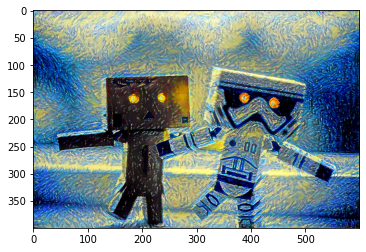

In [ ]:
for cnt in range(total_steps):
  total_loss, content_loss, style_loss, tv_loss = tuning_step(generated_img)
  with torch.no_grad():
    if cnt%100 == 0:
      save_img(generated_img,"/content/outputs",cnt)   
